In [ ]:
!pip install fbm

In [ ]:
import numpy as np
import torch
import torch.nn as nn
np.random.seed(234198)
#import os

#import atexit
#import csv
import itertools
#import multiprocessing
#import socket
import random
import time
#import psutil

#from absl import app
#from absl import flags
#import shutil
import scipy.stats

import math
import matplotlib.pyplot as plt
from fbm import FBM # for fractional BS
#import joblib
import torch.optim as optim
import torch.utils.data as tdata

In [ ]:
"""  
simulate trajectories of stock prices: s_0, s_1, ..., s_{paths+1}
there are multiple stocks (assets) and multiple dates (periods)
1) geometric BM
2) fractional BM
could do also
3) mean reverting BM
"""

class BlackScholes:
  def __init__(self, drift, sigma, delta, hurst, spot, assets,  paths, periods,
         maturity, dividend=0):
    self.drift = drift - dividend
    self.sigma = sigma
    self.delta = delta
    self.hurst = hurst
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.dt = self.maturity / self.periods
    self.df = math.exp(-drift * self.dt)

  def generate_paths(self, paths=None):
    """Returns a nparray (paths * periods * assets) with prices."""
    paths = paths or self.paths
    path = np.array([self.generate_one_path() for i in range(paths)]) 
    return path.reshape(path.shape[0], path.shape[2], path.shape[1])

  def drift_fct(self,x):
    return  (self.drift-self.delta-0.5*self.sigma**2)* x

  def diffusion_fct(self,x):
    return self.sigma * x


  def generate_one_path(self):
    """Returns a nparray (assets * periods) with prices."""
    path = np.empty((self.assets, self.periods+1))
    path[:, 0] = self.spot
    for k in range(1, self.periods+1):
      random_numbers = np.random.normal(0, 1, self.assets)
      dW =(random_numbers*np.sqrt(self.dt))
      previous_spots = path[:, k - 1]
      diffusion = (self.diffusion_fct(previous_spots))
      path[:, k] = (
          previous_spots
          + self.drift_fct(previous_spots)* self.dt
          + diffusion*dW) 
    return path   

class FractionalBlackScholes:
  def __init__(self, drift, sigma, delta, hurst, paths, assets, periods, spot,
         maturity, dividend=0):
    self.drift = drift - dividend
    self.sigma = sigma
    self.delta=delta
    self.hurst = hurst
    self.spot = spot
    self.assets = assets
    self.paths = paths
    self.periods = periods
    self.maturity = maturity
    self.dt = self.maturity / self.periods
    self.df = math.exp(-drift * self.dt)
    self.fBM = FBM(n=periods, hurst=self.hurst, length=maturity, method='hosking')

  def drift_fct(self,x):
    return  (self.drift-self.delta-0.5*self.sigma**2)* x

  def diffusion_fct(self,x):
    return self.sigma * x

  def generate_one_path(self):
    """Returns a nparray (assets * periods) with prices."""
    path = np.empty((self.assets, self.periods+1))
    fracBM_noise = np.empty((self.assets, self.periods))
    path[:, 0] = self.spot
    for stock in range(self.assets):
      fracBM_noise[stock, :] = self.fBM.fgn()
    for k in range(1, self.periods+1):
      previous_spots = path[:, k - 1]
      diffusion = self.diffusion_fct(previous_spots)
      path[:, k] = (
          previous_spots
          + self.drift_fct(previous_spots) * self.dt
          + np.multiply(diffusion, fracBM_noise[:,k-1]))
    return path

  def generate_paths(self, paths=None):
    """Returns a nparray (paths * periods * assets) with prices."""
    paths = paths or self.paths
    path = np.array([self.generate_one_path() for i in range(paths)]) 
    return path.reshape(path.shape[0], path.shape[2], path.shape[1])

def draw_stock_model(stockmodel):
    stock_paths = stockmodel

    # draw a path
    one_path = stock_paths[0, 0, :]
    dates = np.array([i for i in range(len(one_path))])
    plt.plot(dates, one_path, label='stock path')
    plt.ylabel('Stock price')
    plt.ylabel('Time')
    plt.legend()
    return plt.show()   

In [ ]:
"""
Neural network
"""

class NetworkDOS(nn.Module):
  def __init__(self, assets, hidden_size):
    super(NetworkDOS, self).__init__()
    H = hidden_size
    self.a1 = nn.Linear(assets, H) 
    self.relu = nn.ReLU()
    self.a2 = nn.Linear(H, H)
    self.a3 = nn.Linear(H, 1)  
    self.sigmoid=nn.Sigmoid()
    
  def forward(self, x):
    out = self.a1(x)
    out = self.relu(out)
    out = self.a2(out)
    out = self.relu(out)
    out = self.a3(out)
    out = self.sigmoid(out)

    return out



# set initial weights of a linear layer of the NN with uniform values and bias=0.01 (or choose zero initial weights)
def init_weights(m):
  if isinstance(m, torch.nn.Linear):
    torch.manual_seed(42)
    # torch.nn.init.zeros_(m.weight)
    torch.nn.init.xavier_uniform_(m.weight)
    m.bias.data.fill_(0.01)

In [ ]:
"""
Train the neural network
"""

class OptimalStoppingOptimization(object):

  def __init__(self, assets, paths, hidden_size, epochs=20, batch_size=2000):
    self.assets = assets
    self.paths = paths
    self.epochs = epochs
    self.batch_size = batch_size
    self.network = NetworkDOS(self.assets, hidden_size=self.assets+40).double()
    self.network.apply(init_weights)

  def _Loss(self, X):
    return -torch.mean(X)

  def train_network(self,  stock_values, current_payoff,
                    future_payoff):
    optimizer = optim.Adam(self.network.parameters())
    future_payoff = torch.from_numpy(future_payoff).double()
    current_payoff = torch.from_numpy(current_payoff).double()
    inputs = stock_values
    X_inputs = torch.from_numpy(inputs).double()

    self.network.train(True)
    ones = torch.ones(len(future_payoff))
    for epoch in range(self.epochs):
      for batch in tdata.BatchSampler(
              tdata.RandomSampler(range(len(X_inputs)), replacement=False),
              batch_size=self.batch_size, drop_last=False):

        optimizer.zero_grad()
        outputs = self.network(X_inputs[batch]).reshape(-1) # probabilities
        values = (current_payoff[batch].reshape(-1) * outputs +
                    future_payoff[batch] * (ones[batch] - outputs))
        loss = self._Loss(values)
        loss.backward()
        optimizer.step()

  def evaluate_network(self, X_inputs):
    self.network.train(False)
    X_inputs = torch.from_numpy(X_inputs).double()
    outputs = self.network(X_inputs)
    return outputs.view(X_inputs.size()[0]).detach().numpy()

In [ ]:
# Payoff
'''
class Payoff(object):
  def __init__(self, strike):
    self.strike =  strike

  def eval(self, X):  #
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)    
'''



class Payoff:
  def eval(self, X):
    raise NotImplemented()

class MaxCall(Payoff):
  def __init__(self, strike):
    self.strike =  strike

  def eval(self, X):
    # print('payoff.eval ', X, type(X))
    payoff = np.max(X, axis=1) - self.strike
    return payoff.clip(0, None)       

In [ ]:
class OptionPricer:
  def __init__(self, model, payoff, nb_epochs=20,  hidden_size=10):

    #class model: The stochastic process model of the stock (e.g. Black Scholes).
    self.model = model

    #class payoff: The payoff function of the option (e.g. Max call).
    self.payoff = payoff

    state_size = model.assets
    self.neural_stopping = OptimalStoppingOptimization(state_size, model.paths, hidden_size=hidden_size) #, nb_iters=nb_epochs

  def price(self):
    """It computes the price of an American Option using a backward recusrion.
    """
    model = self.model
    stock_paths = self.model.generate_paths()
    
    disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    
    # create empty objects to store values
    V_mat_test=np.zeros((model.periods+1,model.paths))
    V_est_test=np.zeros(model.periods+1)
    tau_mat_test=np.zeros((model.periods+1,model.paths))
    tau_mat_test[periods,:]=model.periods
    f_mat_test=np.zeros((model.periods+1,model.paths))
    f_mat_test[model.periods,:]=1

    # for N=N
    current_payoff = self.payoff.eval(stock_paths[:, -1, :]) # payoff of the last date
    payoff_0 = self.payoff.eval(stock_paths[:, 0, :])  #[0]
    V_mat_test[model.periods,:]=current_payoff*disc_factor*model.periods #PV terminal exercise price
    V_est_test[model.periods]=np.mean(V_mat_test[model.periods,:])
    values = current_payoff


    # recursive calc, from N=99 to 0 with steps of -1
    for date in range(stock_paths.shape[1] - 2, 0, -1): 

      # among all stocks and all paths, for a specific date, get max price - strike, hence payoff. you'll have one value for each date
      #current_payoff = payoff.eval(stockmodel[:, date, :])
      stopping_rule = self.stop(stock_paths[:, date, :], 
                                current_payoff,
                                values*disc_factor)
      f_mat_test[date,:]=(stopping_rule > 0.5)*1.0   # 0-1 decision
      tau_mat_test[date,:]=np.argmax(f_mat_test, axis=0) # date in whihc you stopped. you're going backwars, takes most recent date. takes first maximum in the column of f matrix

      for path in range(0, paths):
        tau = tau_mat_test[date,path]
        V_mat_test[date,path]=self.payoff.eval(np.expand_dims(stock_paths[path, int(tau), :], 
                                                              axis=0))*np.exp((date-int(tau))*disc_factor)
      
      V_est_test=np.mean(V_mat_test, axis=1) # mean by row of the paths
      V_std_test=np.std(V_mat_test, axis=1)
      
      maxi = np.max(np.array([np.mean(payoff_0), np.mean(V_est_test)]))  
      spot_payoff = np.mean(payoff_0)
    return {'mean': V_est_test, 'sd':  V_std_test,'SE': V_std_test/(np.sqrt(model.paths)), 'maxi': maxi, 'spot_payoff' : spot_payoff}


  def stop(self, stock_values, current_payoff,
           future_payoff):
    
    self.neural_stopping.train_network(
      stock_values,
      current_payoff.reshape(-1, 1),
      future_payoff)

    inputs = stock_values
    stopping_rule = self.neural_stopping.evaluate_network(inputs)
    return stopping_rule    

In [ ]:


drift= 0.2; sigma= 0.05; delta=0.1; hurst=0.75; paths=5000;periods=9; maturity= 3; assets=10; spot=90
_STOCK_MODELS = {"BlackScholes": BlackScholes, 'FractionalBlackScholes':FractionalBlackScholes,}
hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1, 'hurst':0.75,  'paths':5000, 'periods': 9, 'maturity': 3., 'assets':10,  'spot':90,}
stock_model1_ = _STOCK_MODELS["BlackScholes"](**hyperparam_test_stock_models).generate_paths()
neural_stopping = OptimalStoppingOptimization(assets, paths, hidden_size=10)


def eval(X, strike=90):
  payoff = np.max(X, axis=1) - strike
  return payoff.clip(0, None) 

def stop(stock_values, current_payoff,
           future_payoff):
    
    neural_stopping.train_network(
      stock_values,
      current_payoff.reshape(-1, 1),
      future_payoff)

    inputs = stock_values
    stopping_rule = neural_stopping.evaluate_network(inputs)
    return stopping_rule   


disc_factor = np.math.exp((-drift) * maturity/(periods))
V_mat_test=np.zeros((periods+1,paths))
V_est_test=np.zeros(periods+1)
tau_mat_test=np.zeros((periods+1,paths))
tau_mat_test[periods,:]=periods
f_mat_test=np.zeros((periods+1,paths))
f_mat_test[periods,:]=1

# for N=N

current_payoff = eval(stock_model1_[:, -1, :]) # payoff of the last date
payoff_0 = eval(stock_model1_[:, 0, :])  #[0]
V_mat_test[periods,:]=current_payoff*disc_factor*periods #PV terminal exercise price
V_est_test[periods]=np.mean(V_mat_test[periods,:])
values = current_payoff

'''
for date in range(stock_model1_.shape[1] - 2, 0, -1): 

      # among all stocks and all paths, for a specific date, get max price - strike, hence payoff. you'll have one value for each date
      #current_payoff = payoff.eval(stockmodel1[:, date, :])
      stopping_rule = stop(stock_model1_[:, date, :], 
                                current_payoff,
                                values*disc_factor)
      f_mat_test[date,:]=(stopping_rule > 0.5)*1.0   # 0-1 decision
      tau_mat_test[date,:]=np.argmax(f_mat_test, axis=0)
      path=2
      tau = tau_mat_test[date,path]
      pay = payoff_.eval(np.expand_dims(stock_model1_[path, int(tau), :], axis=0))*np.exp((date-int(tau))*disc_factor)

print(pay)      
'''

date = 5
current_payoff = eval(stock_model1_[:, date, :])
stopping_rule = stop(stock_model1_[:, date, :], 
                                current_payoff,
                                values*disc_factor)
print(stopping_rule, len(stopping_rule))
print(current_payoff, len(current_payoff))

[3.39594337e-31 3.65999980e-29 1.16451339e-30 ... 9.95958407e-28
 9.61840057e-30 4.86765510e-29] 5000
[40.02860858 37.62083436 40.20782784 ... 21.75215428 33.50768857
 24.24693716] 5000


In [ ]:
class DeepOptimalStopping(OptionPricer):

  def __init__(self, model, payoff, nb_epochs=20,  hidden_size=10):
    super().__init__(model, payoff)
    state_size = model.assets
    self.neural_stopping = OptimalStoppingOptimization(state_size, model.paths, hidden_size=hidden_size) #, nb_iters=nb_epochs

  def stop(self, stock_values, current_payoff,
           future_payoff):
    
    self.neural_stopping.train_network(
      stock_values,
      current_payoff.reshape(-1, 1),
      future_payoff)

    inputs = stock_values
    stopping_rule = self.neural_stopping.evaluate_network(inputs)
    return stopping_rule    

In [ ]:
_STOCK_MODELS = {"BlackScholes": BlackScholes, 'FractionalBlackScholes':FractionalBlackScholes,}
hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1, 'hurst':0.75,  'paths':5000, 'periods': 9, 'maturity': 3., 'assets':10,  'spot':90,}
stock_model1_ = _STOCK_MODELS["BlackScholes"](**hyperparam_test_stock_models)
stock_model2_ = _STOCK_MODELS["FractionalBlackScholes"](**hyperparam_test_stock_models)


paths=hyperparam_test_stock_models['paths']
drift=hyperparam_test_stock_models['drift']
spot=hyperparam_test_stock_models['spot']
sigma=hyperparam_test_stock_models['sigma']

maturity=hyperparam_test_stock_models['maturity']
assets=hyperparam_test_stock_models['assets']
periods=hyperparam_test_stock_models['periods']
strike=90
# dividend not yet here

nb_epochs=10
hidden_size=10


_ALGOS = {"DOS": OptionPricer, 
          }
algo="DOS"
payoff="MaxCall"

_PAYOFFS = {"MaxCall": MaxCall,
           }
          
payoff_ = _PAYOFFS[payoff](strike)
pricing = _ALGOS[algo](stock_model2_, payoff_, nb_epochs=nb_epochs,hidden_size=hidden_size)

In [ ]:
t_begin = time.time()
price_dos = pricing.price()


31.176392088183015


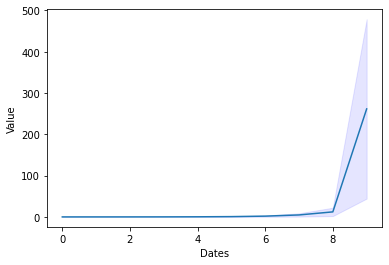

In [ ]:
# extract the objects

Mean_est_dos = 'mean'
Sd_est_dos = 'sd'
SE_est_dos = 'SE'
max_dos = 'maxi'
pay0_dos = 'spot_payoff'

Mean_estimate_dos = price_dos.get(Mean_est_dos, 0)
Sd_estimate_dos = price_dos.get(Sd_est_dos, 0)
SE_estimate_dos = price_dos.get(SE_est_dos, 0)
max_estimate_dos = price_dos.get(max_dos, 0)
payoff0_dos = price_dos.get(pay0_dos, 0)

z=scipy.stats.norm.ppf(0.975)
lower=Mean_estimate_dos - z*Sd_estimate_dos
upper=Mean_estimate_dos + z*Sd_estimate_dos

dates = np.array([i for i in range(len(Mean_estimate_dos))])
fig, ax = plt.subplots()
ax.plot(dates,Mean_estimate_dos)
ax.fill_between(dates, (Mean_estimate_dos-z*Sd_estimate_dos), (Mean_estimate_dos+z*Sd_estimate_dos), color='b', alpha=.1)
plt.xlabel("Dates")
plt.ylabel("Value")

print(max_estimate_dos)

In [ ]:
# optimal switching

'''
paths same
payoff same: 
NN same



need:


'''

'\npaths same\npayoff same: \nNN same\n\n\n\nneed:\n\n\n'

In [ ]:
# generate underlying stochastic process
_STOCK_MODELS = {"BlackScholes": BlackScholes, 'FractionalBlackScholes':FractionalBlackScholes,}
hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1, 'hurst':0.75,  'paths':1, 'periods': 3, 'maturity': 3., 'assets':1,  'spot':90,}
stock_model_switching = _STOCK_MODELS["BlackScholes"](**hyperparam_test_stock_models)
drift= 0.2; sigma= 0.05; delta= 0.1; hurst=0.75; paths=1; periods=3; maturity= 3; assets=1; spot=90; regime=2; strike=90

def eval(X, strike=90):
  payoff = np.max(X, axis=1) - strike
  return payoff.clip(0, None)      


disc_factor = np.math.exp((-drift) * maturity/(periods))
stock_paths = stock_model_switching.generate_paths()

# create empty objects to store values

# Vmat will contain value function estimates
# value function estimate should distinguish the two types of regimes too
Y_it=np.zeros((periods+1,paths, regime))
#print("shape Y_it",Y_it.shape) #(4, 1, 2)
# Y_it will take mean of Y_it estimates across paths (for each regime)
Y_it_estimate=np.zeros((periods+1, regime))
print(Y_it_estimate)
#print("shape Y_it_est",Y_it_estimate.shape) #(4, 2)

# fmatrix records stopping decisions 
f_theta=np.zeros((periods+1,paths, regime))
f_theta[periods,:,:]=1 # at maturity we switch
#print("f_theta ",f_theta.shape) #(4, 1, 2)

#tau matrix will record stopping times, at maturity we assume the process stops
# once a stopping decision is recorded, we take the time at which the stopping decision occured (hence the stopping time)
tau=np.zeros((periods+1,paths, regime))
tau[periods,:,:]=periods


# for N=N
final_payoff = eval(stock_paths[:, -1, :], 90) # payoff of the last date --- \gamma_i or \gamma_j
payoff_0 = eval(stock_paths[:, 0, :])  #[0] #initial payoff 
print(final_payoff)
'''
Y_it[periods,:,;]=final_payoff*disc_factor*periods #PV terminal exercise price
Y_it_estimate[periods]=np.mean(Y_it[periods,:,:])
values = final_payoff

# stop function bit
state_size = assets
neural_stopping = OptimalStoppingOptimization(state_size, paths, hidden_size=10)

date=2
stock_values=stock_paths[:, date, :]
neural_stopping.train_network(stock_values,final_payoff.reshape(-1, 1), values*disc_factor) 
inputs = stock_values
stopping_rule = neural_stopping.evaluate_network(inputs)
f_theta[date,:,:]=(stopping_rule > 0.5)*1.0   # 0-1 decision
tau[date,:,:]=np.argmax(f_theta, axis=0)

#def stop(self, stock_values, current_payoff,
#        future_payoff):
#  
#  self.neural_stopping.train_network(
#    stock_values,
#    final_payoff.reshape(-1, 1),
#    future_payoff)

#  inputs = stock_values
#  stopping_rule = self.neural_stopping.evaluate_network(inputs)
#  return stopping_rule 

 '''

[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[15.69263449]


'\nY_it[periods,:,;]=final_payoff*disc_factor*periods #PV terminal exercise price\nY_it_estimate[periods]=np.mean(Y_it[periods,:,:])\nvalues = final_payoff\n\n# stop function bit\nstate_size = assets\nneural_stopping = OptimalStoppingOptimization(state_size, paths, hidden_size=10)\n\ndate=2\nstock_values=stock_paths[:, date, :]\nneural_stopping.train_network(stock_values,final_payoff.reshape(-1, 1), values*disc_factor) \ninputs = stock_values\nstopping_rule = neural_stopping.evaluate_network(inputs)\nf_theta[date,:,:]=(stopping_rule > 0.5)*1.0   # 0-1 decision\ntau[date,:,:]=np.argmax(f_theta, axis=0)\n\n#def stop(self, stock_values, current_payoff,\n#        future_payoff):\n#  \n#  self.neural_stopping.train_network(\n#    stock_values,\n#    final_payoff.reshape(-1, 1),\n#    future_payoff)\n\n#  inputs = stock_values\n#  stopping_rule = self.neural_stopping.evaluate_network(inputs)\n#  return stopping_rule \n\n '

In [ ]:
class SwitchingPricer:
  def __init__(self, model, payoff, nb_epochs=20,  hidden_size=10):

    #class model: The stochastic process model of the stock (e.g. Black Scholes).
    self.model = model

    #class payoff: The payoff function of the option (e.g. Max call).
    self.payoff = payoff

    state_size = model.assets
    self.neural_stopping = OptimalStoppingOptimization(state_size, model.paths, hidden_size=hidden_size) #, nb_iters=nb_epochs

  def price(self):
    """It computes the price of an American Option using a backward recusrion.
    """
    model = self.model
    stock_paths = self.model.generate_paths()
    
    disc_factor = np.math.exp((-model.drift) * model.maturity/(model.periods))
    
    # create empty objects to store values
    V_mat_test=np.zeros((model.periods+1,model.paths))
    V_est_test=np.zeros(model.periods+1)
    tau_mat_test=np.zeros((model.periods+1,model.paths))
    tau_mat_test[periods,:]=model.periods
    f_mat_test=np.zeros((model.periods+1,model.paths))
    f_mat_test[model.periods,:]=1

    # for N=N
    final_payoff = self.payoff.eval(stock_paths[:, -1, :]) # payoff of the last date
    payoff_0 = self.payoff.eval(stock_paths[:, 0, :])  #[0]
    V_mat_test[model.periods,:]=final_payoff*disc_factor*model.periods #PV terminal exercise price
    V_est_test[model.periods]=np.mean(V_mat_test[model.periods,:])
    values = final_payoff


    # recursive calc, from N=99 to 0 with steps of -1
    for date in range(stock_paths.shape[1] - 2, 0, -1): 

      # among all stocks and all paths, for a specific date, get max price - strike, hence payoff. you'll have one value for each date
      #final_payoff = payoff.eval(stockmodel[:, date, :])
      stopping_rule = self.stop(stock_paths[:, date, :], 
                                final_payoff,
                                values*disc_factor)
      f_mat_test[date,:]=(stopping_rule > 0.5)*1.0   # 0-1 decision
      tau_mat_test[date,:]=np.argmax(f_mat_test, axis=0) # date in whihc you stopped. you're going backwars, takes most recent date. takes first maximum in the column of f matrix

      for path in range(0, paths):
        tau = tau_mat_test[date,path]
        V_mat_test[date,path]=self.payoff.eval(np.expand_dims(stock_paths[path, int(tau), :], 
                                                              axis=0))*np.exp((date-int(tau))*disc_factor)
      
      V_est_test=np.mean(V_mat_test, axis=1) # mean by row of the paths
      V_std_test=np.std(V_mat_test, axis=1)
      
      maxi = np.max(np.array([np.mean(payoff_0), np.mean(V_est_test)]))  
      spot_payoff = np.mean(payoff_0)
    return {'mean': V_est_test, 'sd':  V_std_test,'SE': V_std_test/(np.sqrt(model.paths)), 'maxi': maxi, 'spot_payoff' : spot_payoff}


  def stop(self, stock_values, current_payoff,
           future_payoff):
    
    self.neural_stopping.train_network(
      stock_values,
      final_payoff.reshape(-1, 1),
      future_payoff)

    inputs = stock_values
    stopping_rule = self.neural_stopping.evaluate_network(inputs)
    return stopping_rule    

In [ ]:
import numpy as np
import scipy as spy
def MonteCarlo(M,N,T,S0,A,B):
  dt = 1/N
  S = np.zeros((M,int(T*N)+1))
  S[:,0] = S0
  eps = np.random.normal(0, 1, (M,int(N*T)))
  S[:,1:] = np.exp((A-0.5*B**2)*dt + eps*B*np.sqrt(dt));
  S = np.cumprod(S, axis = 1);
  return S

TypeError: ignored

In [ ]:
# price the option using RL - fitted Q iteration

# dimension stockmodel (paths * periods * assets)

In [ ]:
import math, time
import numpy as np
from itertools import combinations

In [ ]:
lst = list(range(assets))
len([list(x) for x in combinations(lst, 2)])
print(enumerate(range(paths)))

In [ ]:
class BasisFunctions:
    def __init__(self, assets):
        self.assets = assets
        lst = list(range(self.assets)) # range of stocks [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        self.combs =  [list(x) for x in combinations(lst, 2)] # n chooses 2
        self.nb_base_fcts = 1 + 2 * self.assets + len(self.combs) # 66
        # print("self.nb_base_fcts", self.nb_base_fcts)
        # print("assets",  self.assets)

    def base_fct(self, i, x):
        bf=np.nan
        if (i == 0):
            bf = np.ones_like(x[0]) # (constant)
        elif (i <= self.assets):
            bf = x[i-1] # (x1, x2, ..., xn)
        elif (self.assets < i <= 2 * self.assets):
            k = i - self.assets - 1
            bf = x[k] ** 2 # (x1^2, x2^2, ..., xn^2)
        elif (i > 2 * self.assets):
            k = i - 2*self.assets -1
            bf = x[self.combs[k][0]] * x[self.combs[k][1]] # (x1x2, ..., xn-1xn)
        return bf


class BasisFunctionsLaguerre:
    def __init__(self, assets, K=1):
        self.assets = assets
        self.nb_base_fcts = 1 + 3 * self.assets
        self.K = K

    def base_fct(self, i, x):
        bf=np.nan
        x = x / self.K
        if (i == 0):
            bf = np.ones_like(x[0]) # (constant)
        elif (i <= self.assets):
            bf = np.exp(-x[i-1]/2)
        elif (self.assets < i <= 2 * self.assets):
            k = i - self.assets - 1
            bf = np.exp(-x[k]/2)*(1-x[k])
        elif (i > 2 * self.assets):
            k = i - 2*self.assets -1
            bf = np.exp(-x[k]/2)*(1-2*x[k]+(x[k]**2)/2)
        return bf


class BasisFunctionsLaguerreTime:
    """assumes that the last stock is the current time"""
    def __init__(self, assets, T, K=1):
        self.assets = assets
        self.nb_base_fcts = 1 + 3 * self.assets
        self.T = T
        self.K = K

    def base_fct(self, i, x):
        bf = np.nan
        x = x / self.K
        if (i == 0):
            bf = np.ones_like(x[0]) # (constant)
        elif (i < self.assets):
            bf = np.exp(-x[i-1]/2)
        elif i == self.assets:  # time polynomial
            bf = np.sin(-np.pi*x[i-1]/2*self.K + np.pi/2)
        elif (self.assets < i < 2 * self.assets):
            k = i - self.assets - 1
            bf = np.exp(-x[k]/2)*(1-x[k])
        elif i == 2 *self.assets:  # time polynomial
            k = i - self.assets - 1
            bf = np.log(1 + self.T * (1-x[k]*self.K))
        elif (2 * self.assets < i < 3*self.assets):
            k = i - 2*self.assets -1
            bf = np.exp(-x[k]/2)*(1-2*x[k]+(x[k]**2)/2)
        elif i == 3*self.assets:
            k = i - 2*self.assets -1
            bf = (x[k]*self.K)**2
        return bf

In [ ]:
class FQI_RL(OptionPricer):
  """fitted Q-Iteration base class"""

  def __init__(self, model, payoff, nb_epochs=20):
    self.model = model
    self.payoff = payoff
    self.nb_epochs = nb_epochs
    self.nb_base_fcts = 0


  def get_indicator_stop(self, payoff, continuation_value):
    return max(payoff, continuation_value)

  def get_contribution_u(
      self, payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value):
    del payoff
    del discount_factor
    del continuation_value
    return np.outer(evaluated_bases, evaluated_bases)

  def evaluate_bases(self, stock_paths, path, date, periods):
    raise NotImplementedError

  def evaluate_bases_all(self, stock_paths):
    """
    Args:
     stock_price (np.array, shape [paths, assets, periods])
    Returns:
     evaluated basis functions
      (np.array, shape [paths, periods, nb_base_fcts])
    """
    raise NotImplementedError

  def price(self):
    #t1 = time.time()
    stock_paths = self.model.generate_paths()
    #print("time path gen: {}".format(time.time() - t1), end=" ")
    paths, periods, assets = stock_paths.shape
    matrixU = np.zeros((self.nb_base_fcts, self.nb_base_fcts), dtype=float)
    vectorV = np.zeros(self.nb_base_fcts, dtype=float)
    weights = np.zeros(self.nb_base_fcts, dtype=float)
    deltaT = self.model.maturity / periods
    discount_factor = math.exp(-self.model.drift * deltaT)

    for epoch in range(self.nb_epochs):
      for i_path, path in enumerate(range(paths)):
        for date in range(periods - 1):
          payoff = self.payoff.eval([stock_paths[path, date+1, :]])[0]
          evaluated_bases = self.evaluate_bases(stock_paths, path, date, periods)
          next_evaluated_bases  = self.evaluate_bases(stock_paths, path,  date+1, periods)
          continuation_value = np.inner(weights, next_evaluated_bases)
          indicator_stop = self.get_indicator_stop(payoff, continuation_value)
          contribution_u = self.get_contribution_u(
              payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value)
          matrixU += contribution_u
          vectorV += evaluated_bases * np.asarray(discount_factor) * np.asarray(indicator_stop)

      weights = np.linalg.solve(matrixU, vectorV)

    paths, periods, assets = stock_paths.shape
    prices = np.zeros(paths, dtype=float)
    for path in range(paths):
      for date in range(periods):
        evaluated_bases = self.evaluate_bases(stock_paths, path, date, periods)
        payoff = self.payoff.eval([stock_paths[path, date, :]])[0]
        continuation_value = np.inner(weights, evaluated_bases)
        continuation_value = max(continuation_value, 0)
        if payoff > continuation_value or (date == periods-1):
          prices[path] = payoff * (discount_factor ** date)
          break
    return np.mean(prices)

In [ ]:
'''

stock_paths = stock_model1_.generate_paths()
paths, periods, assets = stock_paths.shape
nb_base_fcts = 0
matrixU = np.zeros((nb_base_fcts, nb_base_fcts), dtype=float)
vectorV = np.zeros(nb_base_fcts, dtype=float)
weights = np.zeros(nb_base_fcts, dtype=float)
deltaT = maturity / periods
discount_factor = math.exp(-drift * deltaT)

path = 3
date=3
def get_indicator_stop(payoff, continuation_value):
    return max(payoff, continuation_value)

def get_contribution_u(payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value):
    del payoff
    del discount_factor
    del continuation_value
    return np.outer(evaluated_bases, evaluated_bases)

def evaluate_bases(stock_paths, path, date, periods):
  raise NotImplementedError


payoff = payoff_.eval([stock_paths[path, date+1, :]])[0] # payoff over the stocks
print(payoff)
#evaluated_bases = evaluate_bases(stock_paths, path, date, periods)
#print(evaluate_bases)
next_evaluated_bases  = evaluate_bases(stock_paths, path,  date+1, periods)
continuation_value = np.inner(weights, next_evaluated_bases)
print(next_evaluated_bases)
indicator_stop = get_indicator_stop(payoff, continuation_value)
contribution_u = get_contribution_u(
    payoff, evaluated_bases, next_evaluated_bases, discount_factor, continuation_value)
matrixU += contribution_u
vectorV += evaluated_bases * np.asarray(discount_factor) * np.asarray(indicator_stop)
'''

In [ ]:
class FQIFast(FQI_RL):
    """ Computes the american option price using FQI.
    """

    def __init__(self, model, payoff, nb_epochs=20):
        super().__init__(model, payoff, nb_epochs)
        self.bf = BasisFunctions(self.model.assets + 2)
        self.nb_base_fcts = self.bf.nb_base_fcts

    def evaluate_bases(self, stock_paths, path, date, periods):
        raise NotImplementedError

    def evaluate_bases_all(self, stock_price):
        """ see base class"""
        time = np.expand_dims(np.repeat(np.expand_dims(
            np.linspace(0, 1, stock_price.shape[2]), 0), stock_price.shape[0], axis=0), 1)
        stocks = np.concatenate([stock_price, time, 1-time], axis=1)
        stocks = np.transpose(stocks, (1, 0, 2))
        bf = np.concatenate(
            [np.expand_dims(self.bf.base_fct(i, stocks), axis=2)
             for i in range(self.bf.nb_base_fcts)], axis=2)
        return bf

    def price(self):
        t1 = time.time()
        stock_paths = self.model.generate_paths()
        print("time path gen: {}".format(time.time() - t1), end=" ")
        paths, periods, assets = stock_paths.shape
        weights = np.zeros(self.nb_base_fcts, dtype=float)
        deltaT = self.model.maturity / periods
        discount_factor = math.exp(-self.model.drift * deltaT)
        payoffs = self.payoff.eval(stock_paths)
        eval_bases = self.evaluate_bases_all(stock_paths)

        for epoch in range(self.nb_epochs):
            continuation_value = np.dot(eval_bases[:, 1:, :], weights)
            indicator_stop = np.maximum(payoffs[:, 1:], continuation_value)
            matrixU = np.tensordot(eval_bases[:, :-1, :],
                                   eval_bases[:, :-1, :],
                                   axes=([0, 1],[0, 1]))
            vectorV = np.sum(
                eval_bases[:, :-1, :] * discount_factor * np.repeat(
                    np.expand_dims(indicator_stop, axis=2), np.shape(eval_bases)[2],
                    axis=2),
                axis=(0, 1))
            weights = np.linalg.solve(matrixU, vectorV)

        continuation_value = np.maximum(np.dot(eval_bases, weights), 0)
        which = (payoffs > continuation_value)*1
        which[:, -1] = 1
        which[:, 0] = 0
        ex_dates = np.argmax(which, axis=1)
        _ex_dates = ex_dates + np.arange(len(ex_dates))*periods
        prices = payoffs.reshape(-1)[_ex_dates] * discount_factor**ex_dates
        return {'mean': np.mean(prices), 'sd':  np.std(prices),'SE': np.std(prices)/(np.sqrt(paths)), 'prices':prices, 'spot_payoff':payoffs[0, 0]}  #np.max(np.array([np.mean(prices), payoffs[0, 0]]))


class FQIFastLaguerre(FQIFast):
    """ Computes the american option price using FQI
    with weighted Laguerre polynomials.
    """

    def __init__(self, model, payoff, nb_epochs=20, nb_batches=None):
        super().__init__(model, payoff, nb_epochs)
        self.bf = BasisFunctionsLaguerreTime(
            self.model.assets+1, T=model.maturity)
        self.nb_base_fcts = self.bf.nb_base_fcts

    def evaluate_bases_all(self, stock_price):
        """ see base class"""
        time = np.expand_dims(np.repeat(np.expand_dims(
            np.linspace(0, 1, stock_price.shape[1]), 0), stock_price.shape[0], axis=0), 1)
        stocks = np.concatenate([stock_price, time], axis=1)
        stocks = np.transpose(stocks, (1, 0, 2))
        bf = np.concatenate(
            [np.expand_dims(self.bf.base_fct(i, stocks), axis=2)
             for i in range(self.bf.nb_base_fcts)], axis=2)
        return bf

In [ ]:
_STOCK_MODELS = {"BlackScholes": BlackScholes, 'FractionalBlackScholes':FractionalBlackScholes,}
hyperparam_test_stock_models = {'drift': 0.2, 'sigma': 0.05, 'delta': 0.1, 'hurst':0.75,  'paths':5000, 'periods': 9, 'maturity': 3., 'assets':10,  'spot':90,}
stock_model1_ = _STOCK_MODELS["BlackScholes"](**hyperparam_test_stock_models)
stock_model2_ = _STOCK_MODELS["FractionalBlackScholes"](**hyperparam_test_stock_models)


paths=hyperparam_test_stock_models['paths']
drift=hyperparam_test_stock_models['drift']
spot=hyperparam_test_stock_models['spot']
sigma=hyperparam_test_stock_models['sigma']

maturity=hyperparam_test_stock_models['maturity']
assets=hyperparam_test_stock_models['assets']
periods=hyperparam_test_stock_models['periods']
strike=90
# dividend not yet here

nb_epochs=10
hidden_size=10


_ALGOS = {"DOS": DeepOptimalStopping, 
          "FQI": FQIFast, }
algo="FQI"
payoff="MaxCall"
#payoff = MaxCall(strike)
#payoff= Payoff(strike=100)
#payoff="MaxCall"
_PAYOFFS = {"MaxCall": MaxCall,
           }
          
payoff_ = _PAYOFFS[payoff](strike)
if algo in ["DOS"]:
  pricing = _ALGOS[algo](stock_model2_, payoff_, nb_epochs=nb_epochs,hidden_size=hidden_size)
else:
  pricing = _ALGOS[algo](stock_model2_, payoff_, nb_epochs=nb_epochs)

# compact version works like this
#pricing = OptionPricer(stock_model2_, payoff_, nb_epochs=nb_epochs,hidden_size=hidden_size)



In [ ]:
t_begin = time.time()
price_FQI = pricing.price()


In [ ]:
# extract the objects

Mean_est_fqi = 'mean'
Sd_est_fqi = 'sd'
SE_est_fqi = 'SE'
#max_fqi = 'maxi'
pay0_fqi = 'spot_payoff'
prices_fqi = 'prices'

Mean_estimate_fqi = price_FQI.get(Mean_est_fqi, 0)
Sd_estimate_fqi = price_FQI.get(Sd_est_fqi, 0)
SE_estimate_fqi = price_FQI.get(SE_est_fqi, 0)
Prices_fqi=price_FQI.get(prices_fqi, 0)
Pay0_fqi = price_FQI.get(prices_fqi, 0)

z=scipy.stats.norm.ppf(0.975)
lower=Mean_estimate_fqi - z*Sd_estimate_fqi
upper=Mean_estimate_fqi + z*Sd_estimate_fqi

print(Pay0_fqi, Mean_estimate_fqi)
dates = np.array([i for i in range(len(Prices_fqi))])
fig, ax = plt.subplots()
ax.plot(dates,Prices_fqi)
ax.fill_between(dates, (Prices_fqi-z*Sd_estimate_fqi), (Prices_fqi+z*Sd_estimate_fqi), color='b', alpha=.1)
plt.xlabel("Dates")
plt.ylabel("Value")
print(Pay0_fqi, Mean_estimate_fqi)
print(np.max(np.array([np.mean(Mean_estimate_fqi), np.mean(Pay0_fqi)])))